<a href="https://colab.research.google.com/github/Pumafi/problem_solving_rl_pumafi/blob/main/initial_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARC-AGI

Ferdinand Bhavsar

PhD student, Mines Paris

In [21]:
RUNNING_IN_COLAB = True

%cd /content

if RUNNING_IN_COLAB:
    REPO_URL = 'https://github.com/Pumafi/problem_solving_rl_pumafi'
    BRANCH   = 'main'
    REPO_DIR = 'problem_solving_rl_pumafi'

    from pathlib import Path

    if Path(REPO_DIR).is_dir():
      !rm -rf {REPO_DIR}

    # Download the repository
    if not Path(REPO_DIR).is_dir():
        !git clone --branch {BRANCH} --depth=1 -- {REPO_URL} {REPO_DIR}

    %cd {REPO_DIR}

/content
Cloning into 'problem_solving_rl_pumafi'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 404.43 KiB | 1.09 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/problem_solving_rl_pumafi


### Imports

In [22]:
from tensorflow import keras
import pandas as pd
import numpy as np

import random
import math
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from matplotlib import colors


from scipy.stats import kde
from sklearn.metrics.pairwise import euclidean_distances

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, losses
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [23]:
# Load code from the repo
from utils.data_handling import get_color_map, pad_to_shape, preprocess_challenge_data
from utils.preprocess_metalearning_data import filter_and_split_inputs

### Utilities

Get color map (took from some random code I had lying around, so the colors are not the ones from ARC-AGI

### Dataset Loading

In [24]:
import json

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

training_challenges = load_json('./data/arc-agi_training_challenges.json')
training_solutions = load_json('./data/arc-agi_training_solutions.json')
evaluation_challenges = load_json('./data/arc-agi_evaluation_challenges.json')

print("Data loaded successfully.")
print(f"Training tasks: {len(training_challenges)}")
print(f"Evaluation tasks: {len(evaluation_challenges)}")

Data loaded successfully.
Training tasks: 400
Evaluation tasks: 400


Preprocess the challenge data (I'm not touching the indentation, it was a nightmare of using jupyter AND colab for some tests)

In [25]:
# all inputs for meta learning, then the training data for latter
challenge_propositioner_inputs, _, _, _, _ = preprocess_challenge_data(training_challenges, training_solutions)
print(len(challenge_propositioner_inputs))

400


In [26]:
# visualize data types
print(type(challenge_propositioner_inputs))
print(type(challenge_propositioner_inputs[0]))
print(type(challenge_propositioner_inputs[0][0]))
print(type(challenge_propositioner_inputs[0][0][0]))

<class 'list'>
<class 'list'>
<class 'tuple'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [27]:
# In order of access we have:
#     challenge_propositioner_inputs [problem_nb (list)] [example_nb (list)] [0/1 - input/output (tuple)] -> [30, 30, 10] (ndarray)

# Visualize the size of examples sets (NB: All have at least 2 examples, but 2 is to few for my idea)
for i in range(5):
  print("Problem nb ", i +1, " | nb examples: ", len(challenge_propositioner_inputs[i]))

print("\nSize of one grid: ", challenge_propositioner_inputs[0][0][0].shape)

Problem nb  1  | nb examples:  5
Problem nb  2  | nb examples:  5
Problem nb  3  | nb examples:  3
Problem nb  4  | nb examples:  2
Problem nb  5  | nb examples:  3

Size of one grid:  (30, 30, 10)


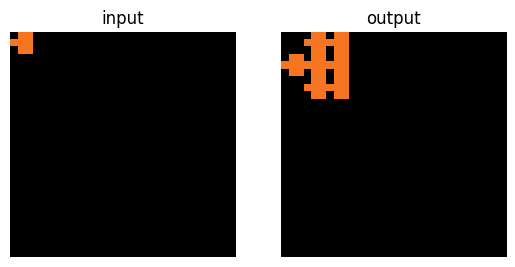

In [28]:
cmap, norm = get_color_map(number_of_categories=9)

plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(np.argmax(challenge_propositioner_inputs[0][0][0], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('output')
plt.imshow(np.argmax(challenge_propositioner_inputs[0][0][1], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
plt.axis('off')
plt.show()

In [29]:
training_z, training_x, training_y = filter_and_split_inputs(challenge_propositioner_inputs)

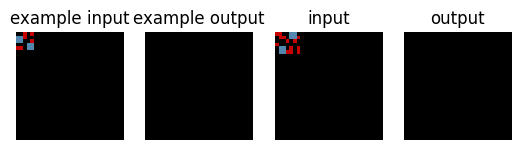

[1]
-------------------------------------------------------------------


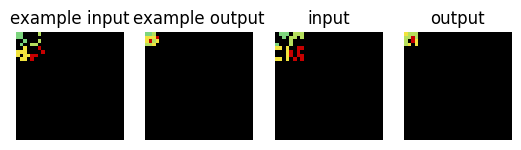

[1]
-------------------------------------------------------------------


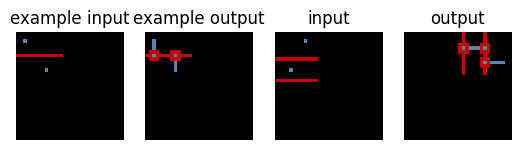

[0]
-------------------------------------------------------------------


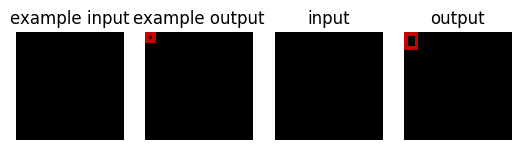

[1]
-------------------------------------------------------------------


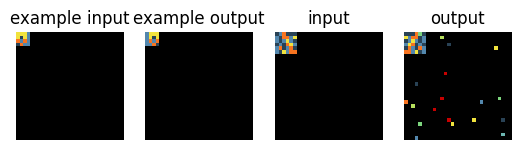

[0]
-------------------------------------------------------------------


In [30]:
plot_fail_success_examples = True

if plot_fail_success_examples:
    cmap, norm = get_color_map(number_of_categories=9)
    for i in range(5):

        plt.subplot(1, 4, 1)
        plt.title('example input')
        plt.imshow(np.argmax(training_z[i][0][0], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.title('example output')
        plt.imshow(np.argmax(training_z[i][0][1], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis('off')
        plt.subplot(1, 4, 3)
        plt.title('input')
        plt.imshow(np.argmax(training_x[i][0], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis('off')
        plt.subplot(1, 4, 4)
        plt.title('output')
        plt.imshow(np.argmax(training_x[i][1], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis('off')
        plt.show()
        print(training_y[i])
        print("-------------------------------------------------------------------")

In [31]:
print(training_z.shape, training_x.shape, training_y.shape)

(1400, 2, 2, 30, 30, 10) (1400, 2, 30, 30, 10) (1400, 1)


# Model

In [32]:
import tensorflow as tf

In [33]:
@tf.function
def parametric_convolution(input_features, filters):
    # Pre-Treatement
    # output = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(input)

    # Core
    output_list = []
    for b in range(input_features.shape[0]):
        output_list.append(tf.nn.depthwise_conv2d(tf.expand_dims(input_features[b], axis=0),
                                                  tf.expand_dims(filters[b], axis=-1),
                                                  strides=[1, 1, 1, 1], padding='SAME'))
    outputs = tf.stack(output_list)
    return tf.squeeze(outputs, axis=1)

In [34]:
class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()

        # Z Layers
        self.concat_original = tf.keras.layers.Concatenate(axis=-1)

        self.conv_z_1 = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same",
                                    activation=keras.layers.LeakyReLU(negative_slope=0.2))
        self.pool_z_1 = layers.MaxPooling2D()
        self.conv_z_2 = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same",
                                    activation=keras.layers.LeakyReLU(negative_slope=0.2))
        self.pool_z_2 = layers.MaxPooling2D()
        self.conv_z_3 = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same",
                                    activation=keras.layers.LeakyReLU(negative_slope=0.2))
        self.pool_z_3 = layers.MaxPooling2D()

        self.concat = tf.keras.layers.Concatenate(axis=-1)

        self.conv_mix_z_1 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same",
                                    activation=keras.layers.LeakyReLU(negative_slope=0.2))
        self.conv_mix_z_2 = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same",
                                    activation=keras.layers.LeakyReLU(negative_slope=0.2))

        # x layers
        self.conv_x_1 = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same",
                                    activation=keras.layers.LeakyReLU(negative_slope=0.2))
        self.pool_x_1 = layers.MaxPooling2D()
        self.conv_x_2 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same",
                                    activation=keras.layers.LeakyReLU(negative_slope=0.2))
        self.conv_x_3 = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same",
                                    activation=keras.layers.LeakyReLU(negative_slope=0.2))
        self.conv_x_4 = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same",
                                    activation=keras.layers.LeakyReLU(negative_slope=0.2))
        self.pool_x_2 = layers.MaxPooling2D()

        # Applied layers
        self.norm = keras.layers.GroupNormalization(4)

        # End Layers

        self.flat = layers.Flatten()

        self.fc1 = layers.Dense(units=120, activation=keras.layers.LeakyReLU(negative_slope=0.2))
        self.fc2 = layers.Dense(units=84, activation=keras.layers.LeakyReLU(negative_slope=0.2))

        # LAST LAYER - TODO
        self.fc3 = layers.Dense(units=1, activation = 'softmax')

    def call(self, inputs):
        examples_challenges = inputs[0]
        test_challenges = inputs[1]

        examples_challenges_1, examples_challenges_2 = tf.keras.ops.unstack(examples_challenges, axis=1)


        examples_challenges_1 = tf.squeeze(self.concat_original(tf.keras.ops.unstack(examples_challenges_1, axis=1)))
        examples_challenges_2 = tf.squeeze(self.concat_original(tf.keras.ops.unstack(examples_challenges_2, axis=1)))


        z1 = self.conv_z_1(examples_challenges_1)
        z1 = self.pool_z_1(z1)
        z1 = self.conv_z_2(z1)
        z1 = self.pool_z_2(z1)
        z1 = self.conv_z_3(z1)
        z1 = self.pool_z_3(z1)

        z2 = self.conv_z_1(examples_challenges_2)
        z2 = self.pool_z_1(z2)
        z2 = self.conv_z_2(z2)
        z2 = self.pool_z_2(z2)
        z2 = self.conv_z_3(z2)
        z2 = self.pool_z_3(z2)

        z = self.concat([z1, z2])

        z = self.conv_mix_z_1(z)
        z = self.conv_mix_z_2(z)

        test_challenges = tf.squeeze(self.concat_original(tf.keras.ops.unstack(test_challenges, axis=1)))


        y = self.conv_x_1(test_challenges)
        y = self.pool_x_1(y)
        y = self.conv_x_2(y)
        y = self.conv_x_3(y)

        y = parametric_convolution(y, z)

        y = self.conv_x_4(y)
        y = self.pool_x_2(y)
        y = self.norm(y)
        y = self.flat(y)


        y = self.fc1(y)
        y = self.fc2(y)
        y = self.fc3(y)

        return z

In [35]:
net = Net()
# Build the model
net.build(([None, 2, 2, 30, 30, 10], [None, 2, 30, 30, 10]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'net_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [36]:
tst_ou = net((training_z[:3], training_x[:3]))

In [37]:
net.summary()

Model: "net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ concatenate_2 (Concatenate)          │ (3, 30, 30, 20)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (3, 30, 30, 32)             │           5,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (3, 15, 15, 32)             │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (3, 7, 7, 32)               │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ concatenate_3 (Concatenate)          │ (3, 3, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (3, 3, 3, 64)               │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (3, 3, 3, 128)              │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (3, 30, 30, 32)             │           5,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (3, 15, 15, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (3, 15, 15, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (3, 15, 15, 128)            │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_1                │ (3, 7, 7, 128)              │             256 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (3, 6272)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (3, 120)                    │         752,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (3, 84)                     │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (3, 1)                      │              

 Total params: 1,144,065 (4.36 MB)

 Trainable params: 1,144,065 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
criterion =  tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.5, beta_2=0.99)

In [39]:
training_z.shape, training_x.shape, training_y.shape

((1400, 2, 2, 30, 30, 10), (1400, 2, 30, 30, 10), (1400, 1))

In [40]:
net.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)

history = net.fit(x=(training_z, training_x), y=training_y, batch_size=32, epochs=100, validation_split=0.1)

Epoch 1/100


ValueError: Exception encountered when calling Net.call().

[1mas_list() is not defined on an unknown TensorShape.[0m

Arguments received by Net.call():
  • inputs=('tf.Tensor(shape=(None, 2, 2, 30, 30, 10), dtype=float32)', 'tf.Tensor(shape=(None, 2, 30, 30, 10), dtype=float32)')